# **Overview**

This classification project aims to train several neural network architectures and machine learning models to determine the relevance of news articles to given search queries. For this, we train models on a dataset of web-scraped online news articles and their associated searches and relevance score.

To ensure better performance from our models, data cleaning is first carried out to remove irrelevant features, such as styling code. Using word vectorisation, we first explore standard machine learning techniques such as random forest decision trees and support vector machines. Then, using a combination of article and query information, we test three-layer neural networks to gain an enhanced appreciation for the dimensionality of the dataset and then a deep neural network. Upon separating the input data, we add more layers with wide and deep neural networks. Finally, we test recurrent complex models, namely LSTM and GRU, to exploit retained patterns (or lack thereof) in the data to influence our results.

We find that the relu activation function consistently performs well to ensure learning gradients of parameters do not become increasingly small. Equally, considering all our neural network models, we find the optimal number of neurons (computational units) to consistently be between 100 and 256. Overall, the standard baseline random forest model marginally performed the greatest. One of the recommendations made to improve the performance of the model is to invest resources into pre-trained models.  

# **Method**

Neural networks offer the advantage of sequential training with various dataset sections. Hence, we split the article information and corresponding query information into separate sections. We also kept aside its relevancy metric too. This was done because article bodies for given topics varied within their group and could concern different contexts. Equally, whilst initial inspections showed that the relevance score was typically accurate, there were outlier cases where this score was incorrect.

The bulk of the information in this dataset is text-based except for 'judgement' (binary relevancy scores) and 'topic_id' (nominal categories for queries). The 'body' column required the most cleaning because it included HTML and CSS. Removal of these prevented irrelevant and constant features from affecting the models’s accuracies and training performance.

The dataset was made lowercase to ensure uniform capitalisation amongst terms with identical meanings. Using BeautifulSoup's html parser, HTML was removed. As CSS is occasionally retained within an embedded stylesheet, observations were split into lists at line breaks. This ensured CSS was contained then removed within lists starting with full stops, tab whitespaces, ampersands, etc., whilst legitimate text data lists started with alphanumeric characters. The next step was to remove punctuation and normalise Unicode hex values with the NFKD algorithm.

Common English words (called 'stopwords') were removed to ensure that unimportant words were not included lest our later models generalise poorly and train ineffectively. To reduce data dimensionality and ensure consistent meaning amongst words is not lost, this project uses Natural Language Toolkit libraries to lemmatise our data.  

TfIDf Vectorisation was applied to the cleaned features. The TfIDf Vectorised features were used only in the standard machine learning baseline as this method of vectorisation produced too many inputs (Azzopardi, 2024) which was not efficient to run neutral networks. Hence, Word2Vec was used to vectorise the features for the remainder of the models. For both methods of vectorisation, the combined columns for queries and articles were tokenised separately for the train and test set.  

From the exploratory data analysis, it was found that 84% of the judgement features were not relevant and 16% were relevant. Therefore, stratified validation was adopted as it addresses bias in the target features during the evaluation of the model (Géron, 2019).   

## Packages

In [ ]:
pip install pyarrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 23.8 MB/s eta 0:00:00


In [ ]:
pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 3.0 MB/s eta 0:00:00


In [ ]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import pyarrow as pa
import pyarrow.parquet as pq
from bs4 import BeautifulSoup
from google.colab import drive
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.tokenize import WhitespaceTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from collections import Counter

nltk.download('punkt')
nltk.download('stopwords')

import nltk
nltk.download('stopwords')

stop_words = set(nltk.corpus.stopwords.words('english'))

import unicodedata
from sklearn.pipeline import Pipeline
from scipy.sparse import hstack
import gensim
from gensim.models import Word2Vec
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Model
import tensorflow as tf
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, GRU, concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.feature_extraction.text import TfidfVectorizer






[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
articles = pd.read_parquet('/content/drive/My Drive/Relevance/relevance_train.parquet')
test = pd.read_parquet('/content/drive/My Drive/Relevance/relevance_test.parquet')


Mounted at /content/drive


In [ ]:
# Training set
articles = pd.DataFrame(articles) # raw train dataset
articles_clean = pd.DataFrame(articles) # working training data

# Test set
test = pd.DataFrame(test) # raw train dataset
test_clean = pd.DataFrame(test) # working test data

datasetShapeO, datasetShapeR = articles.shape
print("number of observations: ", datasetShapeO)
print("number of columns: ", datasetShapeR)

In [ ]:
# Checking column types and nulls
articles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19758 entries, 0 to 26231
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   doc_id       19758 non-null  object
 1   judgement    19758 non-null  int64 
 2   author       18185 non-null  object
 3   body         19689 non-null  object
 4   byline       18250 non-null  object
 5   title        19758 non-null  object
 6   topic_id     19758 non-null  int64 
 7   description  19758 non-null  object
 8   narrative    19758 non-null  object
 9   topic_title  19758 non-null  object
dtypes: int64(2), object(8)
memory usage: 1.7+ MB


### Columns to clean

In [ ]:
columns_to_clean = ['body', 'title', 'description', 'narrative', 'topic_title', 'author', 'byline']
columns_to_clean_test = ['body', 'title', 'description', 'narrative', 'topic_title', 'author', 'byline']

In [ ]:
print(articles_clean['body'].iloc[1])

<p>Hurricane Fred, which formed over the weekend in the far eastern Atlantic, is truly one of a kind. Not only has Fred set the record for easternmost hurricane in the tropical Atlantic Ocean, it prompted the very first hurricane warning for the Cape Verde Islands and has provided the first satellite view of a hurricane in the region since weather satellites were launched into space in the early 1960s.</p>\n<p>Hurricane Fred was born from Tropical Depression Six, which formed early Sunday morning just west of the coast of Africa. The system was quickly upgraded to Tropical Storm Fred, remarkably far east in the Atlantic. Then on Sunday night, forecasters at the National Hurricane Center saw enough strength in Fred to make it the second hurricane of the 2015 season, which also made it the easternmost hurricane formation on record in the Atlantic Ocean.</p>\n<p>Sort of. A slight qualifier is needed: Fred now holds the record for the easternmost hurricane formation <em>in the tropics</em>

### Pipeline - cleaning data

In [ ]:
#Defining the classes for the pipeline

class Lowercase:
    def __init__(self, columns_to_clean):
        self.columns_to_clean = columns_to_clean

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        for column in self.columns_to_clean:
            if column in X_copy.columns:
                X_copy[column] = X_copy[column].str.lower()
        return X_copy

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

class RemovingHTML:
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.column] = X_copy[self.column].apply(self.remove_html)
        return X_copy

    def fit_transform(self, X, y=None):
        return self.transform(X)

    def remove_html(self, text):
        if text is None:
            return ""
        soup = BeautifulSoup(text, 'html.parser')
        return soup.get_text()

class RemovingOtherStylingSymbols:
    def __init__(self, columns_to_clean):
        self.columns_to_clean = columns_to_clean

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        for column in self.columns_to_clean:
            if column in X_copy.columns:
                X_copy[column] = X_copy[column].astype(str).apply(self.remove_newlines_tabs)
                X_copy[column] = X_copy[column].apply(self.remove_unicode)
        return X_copy

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

    def remove_newlines_tabs(self, text):
        if pd.isnull(text):
            return ""
        text = text.replace('\\n', ' ').replace('\\t', ' ').replace('\n', ' ')
        return text

    def remove_unicode(self, text):
        if pd.isnull(text):
            return ""
        text = unicodedata.normalize("NFKD", text)
        return text

class RemovingPunctuation:
    def __init__(self, columns_to_clean):
        self.columns_to_clean = columns_to_clean

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        for column in self.columns_to_clean:
            if column in X_copy.columns:
                X_copy[column] = X_copy[column].astype(str).str.replace('[^\w\s]', '', regex=True)
        return X_copy

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

class RemoveStopwords:
    def __init__(self, columns_to_clean, stop_words):
        self.columns_to_clean = columns_to_clean
        self.stop_words = stop_words

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        for column in self.columns_to_clean:
            if column in X_copy.columns:
                X_copy[column] = X_copy[column].apply(lambda text: ' '.join(word for word in text.split() if word.lower() not in self.stop_words))
        return X_copy

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

class Lemmatization:
    def __init__(self, columns_to_clean):
        self.columns_to_clean = columns_to_clean
        self.wspt = WhitespaceTokenizer()
        self.wnl = WordNetLemmatizer()
        nltk.download('wordnet')
        nltk.download('omw-1.4')

    def lemmatize(self, text):
        return ' '.join([self.wnl.lemmatize(w) for w in self.wspt.tokenize(text)])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        for column in self.columns_to_clean:
            if column in X_copy.columns:
                X_copy[column] = X_copy[column].astype(str).apply(self.lemmatize)
        return X_copy

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)


In [ ]:
pipeline = Pipeline([
    ('Lowercase', Lowercase(columns_to_clean)),
    ('RemovingHTML', RemovingHTML(column='body')),
    ('RemovingOtherStylingSymbols', RemovingOtherStylingSymbols(columns_to_clean)),
    ('RemovingPunctuation', RemovingPunctuation(columns_to_clean)),
    ('RemoveStopwords', RemoveStopwords(columns_to_clean, stop_words)),
    ('Lemmatization', Lemmatization(columns_to_clean))
])

# training data
cleaned_articles = articles_clean.copy()
cleaned_articles = pipeline.fit_transform(cleaned_articles)

# test data
cleaned_articles_test = test.copy()
cleaned_articles_test = pipeline.transform(cleaned_articles_test)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
cleaned_articles.info()
cleaned_articles_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19758 entries, 0 to 26231
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   doc_id       19758 non-null  object
 1   judgement    19758 non-null  int64 
 2   author       19758 non-null  object
 3   body         19758 non-null  object
 4   byline       19758 non-null  object
 5   title        19758 non-null  object
 6   topic_id     19758 non-null  int64 
 7   description  19758 non-null  object
 8   narrative    19758 non-null  object
 9   topic_title  19758 non-null  object
dtypes: int64(2), object(8)
memory usage: 1.7+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 4884 entries, 2050 to 24961
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   doc_id       4884 non-null   object
 1   author       4884 non-null   object
 2   body         4884 non-null   object
 3   byline       4884 non-null   object
 4 

##EDA

### EDA re: 'Judgement'

Count of each class in the 'judgement' column:
judgement
0    16653
1     3105
Name: count, dtype: int64


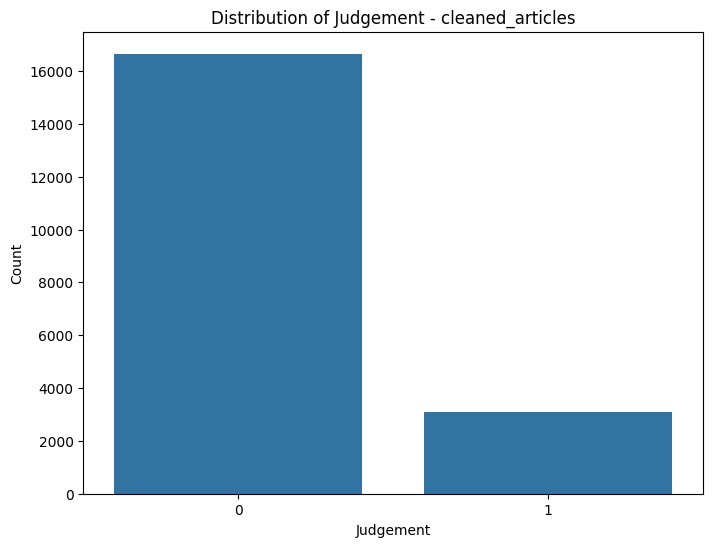

In [ ]:
# Printing the count of each class
judgement_counts = cleaned_articles['judgement'].value_counts()
print("Count of each class in the 'judgement' column:")
print(judgement_counts)

# Visualizing the distribution of'judgement' column
plt.figure(figsize=(8, 6))
sns.countplot(x='judgement', data=cleaned_articles)
plt.title('Distribution of Judgement - cleaned_articles')
plt.xlabel('Judgement')
plt.ylabel('Count')
plt.show()

### EDA re: 'Body'

In [ ]:
# Calculating the length of each bit of text in the 'body' column
cleaned_articles['body_length'] = cleaned_articles['body'].apply(len)

# Distribution of text lengths
plt.figure(figsize=(10, 6))
sns.histplot(cleaned_articles['body_length'], kde=True)
plt.title('Distribution of Text Lengths in the "body" Column')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

In [ ]:
# Basic statistics of text lengths
body_length_stats = cleaned_articles['body_length'].describe()

print("Basic statistics of text lengths in the 'body' column:")
print(body_length_stats)

In [ ]:
# Number of words in the 'body' column
wt_words = cleaned_articles['body'].str.split().apply(len)

print(" words in the 'body' column:")
print(wt_words.sum())

In [ ]:
# Concatenating all text data from the 'body' column and tokenizing the concatenated text into individual words
all_text = ' '.join(cleaned_articles['body'].dropna())

words = nltk.word_tokenize(all_text)

# Frequency of each word
word_freq = Counter(words)

# Top 50 most common words
print("Frequency of the top 50 most common words in the 'body' column:")
print(word_freq.most_common(50))

### EDA re: 'topic_id'

In [ ]:
# Number of unique categories of 'topic_id'
num_categories = cleaned_articles['topic_id'].nunique()

# Print the number of unique categories
print("Number of categories of 'topic_id':", num_categories)

### Word Frequency in body in each topic

####wordcloud

In [ ]:
# Grouping the data by 'topic_id' and concatenate text data within each group
grouped_data = cleaned_articles.groupby('topic_id')['body'].apply(' '.join)

# Word clouds for each group
for topic_id, text in grouped_data.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Topic ID {topic_id}')
    plt.axis('off')
    plt.show()


#### Word Frequency Counts

In [ ]:
word_counts = {}

for topic_id, text in grouped_data.items():
    words = text.split()
    word_freq = Counter(words)

    # Word frequencies in descending order
    sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

    #  Sorted word frequencies for the topic_id
    word_counts[topic_id] = sorted_word_freq

# Most frequent words for each 'topic_id' category
for topic_id, sorted_word_freq in word_counts.items():
    print(f"Most frequent words for Topic ID {topic_id}:")
    for word, freq in sorted_word_freq[:10]:
        print(f"{word}: {freq}")
    print()

## Combine Columns

In [ ]:
def combine_columns(row):
    return ' '.join(str(item) if item is not None else '' for item in row)

cleaned_articles['article_combined'] = cleaned_articles[['title', 'body', 'author', 'byline']].apply(combine_columns, axis=1)
cleaned_articles['query_combined'] = cleaned_articles[['description', 'narrative', 'topic_title']].apply(combine_columns, axis=1)

cleaned_articles_test['article_combined'] = cleaned_articles_test[['title', 'body', 'author', 'byline']].apply(combine_columns, axis=1)
cleaned_articles_test['query_combined'] = cleaned_articles_test[['description', 'narrative', 'topic_title']].apply(combine_columns, axis=1)

In [ ]:
print(cleaned_articles['article_combined'].iloc[1])

## Preprocessing

### Term Frequency - Inverse Document Frequency (TF-IDF)

In [ ]:
tfidf_vectorizer_article = TfidfVectorizer(stop_words='english', max_features=2500) # call vectorizer
tfidf_vectorizer_query = TfidfVectorizer(stop_words='english', max_features=2500)

article_combined_tfidf = tfidf_vectorizer_article.fit_transform(cleaned_articles['article_combined']) #fit our training data to vectorizer
query_combined_tfidf = tfidf_vectorizer_query.fit_transform(cleaned_articles['query_combined'])

article_combined_tfidf_test = tfidf_vectorizer_article.transform(cleaned_articles_test['article_combined']) # fit testing data to vectorizer
query_combined_tfidf_test = tfidf_vectorizer_query.transform(cleaned_articles_test['query_combined'])

X_train_tfidf = hstack([article_combined_tfidf, query_combined_tfidf]) #stack articles and query into array along 2nd dimension
X_test_tfidf = hstack([article_combined_tfidf_test, query_combined_tfidf_test])



### Word Embedding

In [ ]:
def tokenize_texts(text_series):
    return [text.split() for text in text_series]

def get_average_embedding(tokenized_text, model_word2vec):
    embedding_size = model_word2vec.vector_size
    embeddings = [model_word2vec.wv[word] for word in tokenized_text if word in model_word2vec.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(embedding_size)

tokenized_articles = tokenize_texts(cleaned_articles['article_combined'].astype(str))
tokenized_queries = tokenize_texts(cleaned_articles['query_combined'].astype(str))
tokenized_articles_test = tokenize_texts(cleaned_articles_test['article_combined'].astype(str))
tokenized_queries_test = tokenize_texts(cleaned_articles_test['query_combined'].astype(str))

# Combined tokenized articles and queries for Word2Vec training
tokenized_texts = tokenized_articles + tokenized_queries
tokenized_texts_test = tokenized_articles_test + tokenized_queries_test

In [ ]:
# Training Word2Vec model
# note: we are using vector_size=50 to speed up compution

model_word2vec = Word2Vec(sentences=tokenized_texts, vector_size=50, window=5, min_count=1, workers=4)
model_word2vec.train(tokenized_texts, total_examples=len(tokenized_texts), epochs=10)

(112332574, 113673640)

In [ ]:
# Embeddings for articles and queries in training and test set.
articles_embeddings = np.array([get_average_embedding(text, model_word2vec) for text in tokenized_articles])
queries_embeddings = np.array([get_average_embedding(text, model_word2vec) for text in tokenized_queries])

articles_embeddings_test = np.array([get_average_embedding(text, model_word2vec) for text in tokenized_articles_test])
queries_embeddings_test = np.array([get_average_embedding(text, model_word2vec) for text in tokenized_queries_test])


In [ ]:
print("Shape of articles_embeddings:", articles_embeddings.shape)
print("Shape of queries_embeddings:", queries_embeddings.shape)
print("Shape of articles_embeddings_test:", articles_embeddings_test.shape)
print("Shape of queries_embeddings_test:", queries_embeddings_test.shape)


Shape of articles_embeddings: (19758, 50)
Shape of queries_embeddings: (19758, 50)
Shape of articles_embeddings_test: (4884, 50)
Shape of queries_embeddings_test: (4884, 50)


In [ ]:
# Combining the vectorized features from both text columns into a single feature set

X_train_Word = np.concatenate((articles_embeddings, queries_embeddings), axis=1)

X_test_Word = np.concatenate((articles_embeddings_test, queries_embeddings_test), axis=1)


# **Models**

## **Standard Baseline**

For the standard machine learning baseline, logistic regression, multinomial naive bayes, support vector machine and random forest classifier models were developed. Both TfIDf and Word2Vec were used for separate models.

In [ ]:
class MultiModelTrainer:
    def __init__(self, models, n_splits=5):
        self.models = models
        self.n_splits = n_splits
        self.best_model = None
        self.model_accuracies = {}

    def train_and_evaluate(self, X, y):
        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)

        for name, model in self.models:
            fold_accuracies = []

            # Dividing training and validation set with Stratified k-fold cross-validation
            for train_index, val_index in skf.split(X, y):
                X_train, X_val = X[train_index], X[val_index]
                y_train, y_val = y[train_index], y[val_index]

                # fit & evaluate
                model.fit(X_train, y_train)
                score = model.score(X_val, y_val)
                fold_accuracies.append(score)

            # Mean accuracy across folds for the current model
            mean_accuracy = np.mean(fold_accuracies)
            self.model_accuracies[name] = mean_accuracy
            print(f"{name}: Mean accuracy = {mean_accuracy}")

        # Best model based on mean accuracy
        best_model_name = max(self.model_accuracies, key=self.model_accuracies.get)
        self.best_model = [m for n, m in self.models if n == best_model_name][0]
        print(f"\nBest model: {best_model_name} with accuracy = {self.model_accuracies[best_model_name]}")

    def fit_best_model_and_predict(self, X_train, y_train, X_test):
        if not self.best_model:
            raise ValueError("No model has been trained yet.")

        # Fit the best model on the entire training dataset
        self.best_model.fit(X_train, y_train)

        # Predicting on the test dataset
        predictions = self.best_model.predict(X_test)

        return predictions


###Tfdif

In [ ]:
y = articles_clean['judgement'].values

models = [
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('Multinomial Naive Bayes', MultinomialNB()),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Support Vector Machine', SVC(kernel='rbf', gamma='scale', random_state=42))
]

trainer = MultiModelTrainer(models=models, n_splits=5)
trainer.train_and_evaluate(X_train_tfidf, y)
predictions_tfidf = trainer.fit_best_model_and_predict(X_train_tfidf, y, X_test_tfidf)


Logistic Regression: Mean accuracy = 0.8751899790654136
Multinomial Naive Bayes: Mean accuracy = 0.7922361683661288
Random Forest: Mean accuracy = 0.8851100449125265
Support Vector Machine: Mean accuracy = 0.8445690093319275

Best model: Random Forest with accuracy = 0.8851100449125265


###Word2Vec embeddings

In [ ]:
y = articles_clean['judgement'].values

models = [
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Support Vector Machine', SVC(kernel='rbf', gamma='scale', random_state=42))
]

trainer = MultiModelTrainer(models=models, n_splits=5)
trainer.train_and_evaluate(X_train_Word, y)
predictions_tfidf = trainer.fit_best_model_and_predict(X_train_Word, y, X_test_Word)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Logistic Regression: Mean accuracy = 0.8501365154314442
Random Forest: Mean accuracy = 0.890171196345516
Support Vector Machine: Mean accuracy = 0.8580827689807429

Best model: Random Forest with accuracy = 0.890171196345516


In [ ]:
#best model prediction to csv
submission = pd.DataFrame({
    'id': test_clean['doc_id'],
    'judgement': predictions_tfidf
})
submission.to_csv('standardbl_tfidf.csv', index=False)

## **3Layer NN Baseline**

The activation type in the output layer uses a sigmoid function. Then, accuracy is calculated using binary cross-entropy and weights and biases are updated with the Adaptive Moment Estimation optimiser (Géron, 2019, p135 & p356).

Our optimal model used relu and 256 neurons over 10 epochs. Sigmoid and relu  plateau at 128 neurons, whilst tanh peaks at 128 neurons. From 256 neurons, relu and sigmoid decrease in performance. Despite tanh performing better than relu at 32 neurons, relu performs better overall with an optimal number of neurons. The sigmoid activation function returns the poorest accuracy score.  

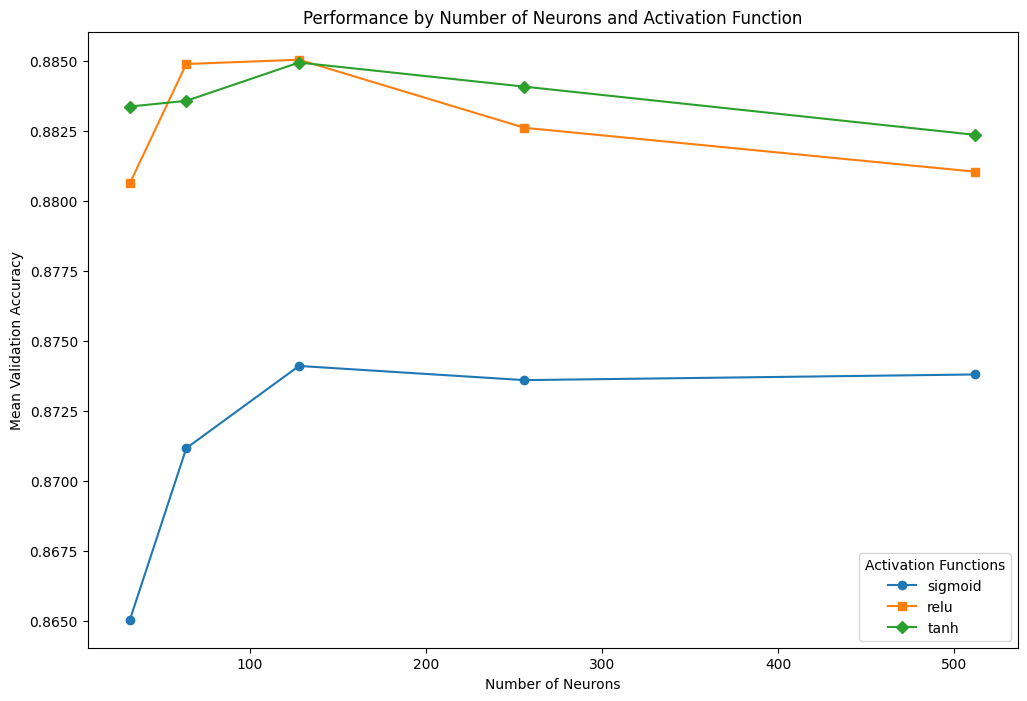

In [ ]:
class BasicNeuralNetwork(Model):
    def __init__(self, input_shape_article, input_shape_query, neurons, activation='relu'):
        super(BasicNeuralNetwork, self).__init__()
        self.input_shape_article = input_shape_article
        self.input_shape_query = input_shape_query
        self.neurons = neurons
        self.activation = activation
        self.build_model()

    def build_model(self):
        input_article = Input(shape=(self.input_shape_article,), name='Article_Input')
        input_query = Input(shape=(self.input_shape_query,), name='Query_Input')
        concatenated_inputs = concatenate([input_article, input_query])
        hidden_layer = Dense(self.neurons, activation=self.activation)(concatenated_inputs)
        output = Dense(1, activation='sigmoid')(hidden_layer)
        self.model = Model(inputs=[input_article, input_query], outputs=output)

    def compile(self, optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def fit(self, x, y, **kwargs):
        return self.model.fit(x, y, **kwargs)

    def evaluate(self, x, y, **kwargs):
        return self.model.evaluate(x, y, **kwargs)

    def predict(self, x, **kwargs):
        return self.model.predict(x, **kwargs)


In [ ]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Parameters
n_splits = 5
epochs = 10
batch_size = 32
neurons_list = [32, 64, 128, 256, 512]
activation_functions = ['relu', 'tanh', 'sigmoid']
y_train = articles_clean['judgement'].values
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Performance for each activation function
performance_records = []

for neurons in neurons_list:
    for activation in activation_functions:
        fold_accuracies = []
        for train_index, val_index in skf.split(articles_embeddings, y_train):
            model = BasicNeuralNetwork(articles_embeddings.shape[1], queries_embeddings.shape[1], neurons, activation) #model reinitialized on iteration thus preventing leakeage from one train to otherds
            model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
            early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

            # Split the data
            articles_train_fold, articles_val_fold = articles_embeddings[train_index], articles_embeddings[val_index]
            queries_train_fold, queries_val_fold = queries_embeddings[train_index], queries_embeddings[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            model.fit([articles_train_fold, queries_train_fold], y_train_fold,
                      validation_data=([articles_val_fold, queries_val_fold], y_val_fold),
                      epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=0)
            val_accuracy = model.evaluate([articles_val_fold, queries_val_fold], y_val_fold, verbose=0)[1]
            fold_accuracies.append(val_accuracy)

        mean_val_accuracy = np.mean(fold_accuracies)
        performance_records.append((neurons, activation, mean_val_accuracy))

# Plotting performance
plt.figure(figsize=(12, 8))
markers = ['o', 's', 'D', '^', 'v', '>', '<', 'p', '*', 'h', 'x']
activations = list(set(record[1] for record in performance_records))
marker_dict = dict(zip(activations, markers[:len(activations)]))

for activation in activations:
    records = [record for record in performance_records if record[1] == activation]
    neurons = [record[0] for record in records]
    accuracies = [record[2] for record in records]

    plt.plot(neurons, accuracies, marker=marker_dict[activation], linestyle='-', label=activation)

plt.xlabel('Number of Neurons')
plt.ylabel('Mean Validation Accuracy')
plt.title('Performance by Number of Neurons and Activation Function')
plt.legend(title="Activation Functions")
plt.show()

# Best configuration
best_record = max(performance_records, key=lambda x: x[2])
print(f"Best Configuration: Neurons: {best_record[0]}, Activation: {best_record[1]}, Mean Validation Accuracy: {best_record[2]}")



# Final model
optimal_neurons = max(performance_records, key=lambda x: x[2])[0]
optimal_activation = max(performance_records, key=lambda x: x[2])[1]
print(f"Using optimal number of neurons: {optimal_neurons} and activation function: {optimal_activation}")

final_model = BasicNeuralNetwork(articles_embeddings.shape[1], queries_embeddings.shape[1], optimal_neurons, optimal_activation)
final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
final_model.fit([articles_embeddings, queries_embeddings], y_train, epochs=epochs, batch_size=batch_size)

# Predictions with the best model
predictions = final_model.predict([articles_test, queries_test])
binary_predictions_3L = (predictions >= 0.5).astype(int)

binary_predictions_3L


In [ ]:
binary_predictions_3L = np.squeeze(binary_predictions_3L)

submission = pd.DataFrame({
    'id': test_clean['doc_id'],
    'judgement': binary_predictions_3L.astype(int)
})

submission.to_csv('submission3L_word.csv', index=False)


## Deep NN models

For the deep neural network model, the articles and queries were fed into the model as two separate inputs.  For this model, the number of layers explored were 3, 4, 5, 6 and 7 with 256 neurons using activations of relu, tanh and sigmoid.  

The most optimum performance of the model occurs when there are 6 layers. There is a slight increase in performance from 5 to 6 layers and the performance decreases slightly when moving to 7 layers.

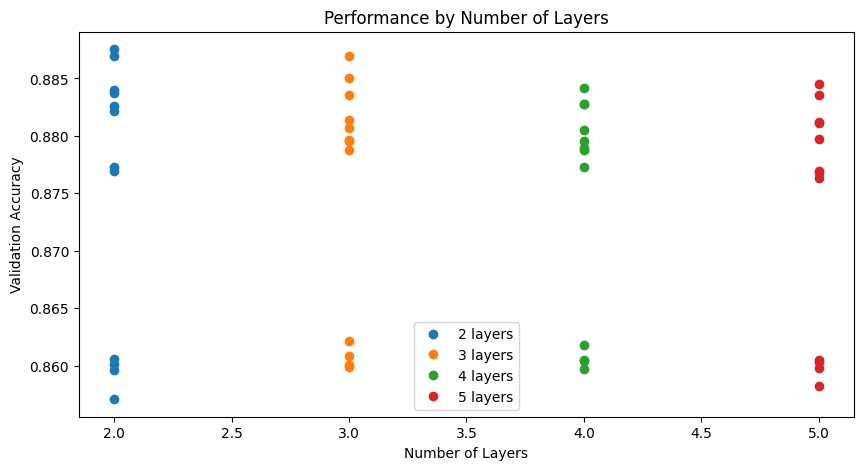



The most optimum performance of the model occurs when the relu activation function is used. The mean validation accuracy for the model is similar for relu, tanh and sigmoid activations.

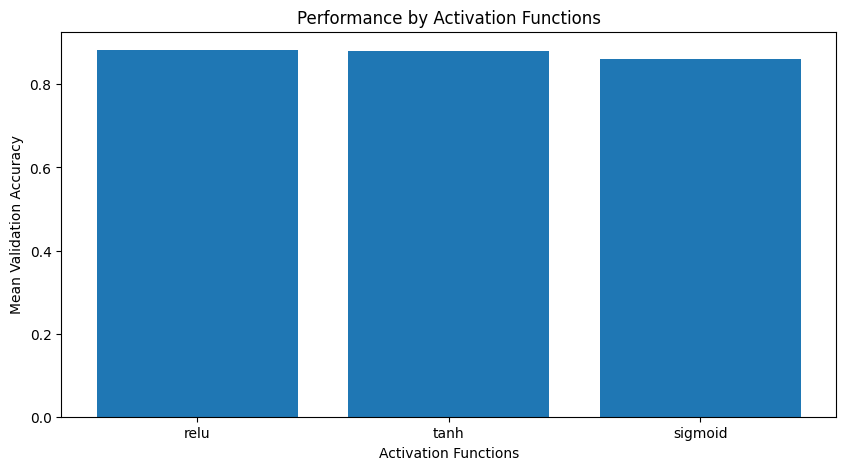

The best configuration for the deep neural network model is 6 layers with 256 neurons, relu activation, initialiser of he_normal and a learning rate of 0.001.


In [ ]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class DeepNNTrainer:
    def __init__(self, input_shape_article, input_shape_query, epochs=10, batch_size=32, n_splits=5):
        self.input_shape_article = input_shape_article
        self.input_shape_query = input_shape_query
        self.epochs = epochs
        self.batch_size = batch_size
        self.n_splits = n_splits
        self.performance_records = {}
        self.best_model = None
        self.best_accuracy = 0

    def build_model(self, num_layers, neurons_per_layer, activation, kernel_initializer='glorot_uniform', kernel_regularizer=None):
        input_article = Input(shape=(self.input_shape_article,), name='Article_Input')
        input_query = Input(shape=(self.input_shape_query,), name='Query_Input')

        # First branch for articles
        x1 = Dense(neurons_per_layer, activation=activation, kernel_initializer=kernel_initializer, kernel_regularizer=self.regularizer(kernel_regularizer))(input_article)
        # Second branch for queries
        x2 = Dense(neurons_per_layer, activation=activation, kernel_initializer=kernel_initializer, kernel_regularizer=self.regularizer(kernel_regularizer))(input_query)

        # Combining the outputs from both branches
        combined = concatenate([x1, x2])

        # Adding additional layers based on num_layers
        for _ in range(num_layers - 1):
            combined = Dense(neurons_per_layer, activation=activation, kernel_initializer=kernel_initializer, kernel_regularizer=self.regularizer(kernel_regularizer))(combined)

        output = Dense(1, activation='sigmoid')(combined)
        model = Model(inputs=[input_article, input_query], outputs=output)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        return model

    def regularizer(self, kernel_regularizer):
        if kernel_regularizer is None:
            return None
        elif kernel_regularizer == "l1":
            return regularizers.l1()
        elif kernel_regularizer == "l2":
            return regularizers.l2()
        elif kernel_regularizer == "l1l2":
            return regularizers.l1_l2()
        else:
            raise ValueError("Not a valid regularizer. Use 'l1', 'l2' or 'l1l2'")

    # Updated train_and_evaluate method to accept and handle two sets of inputs
    def train_and_evaluate(self, articles_train, queries_train, y_train, num_layers_options, neurons_options, activations_options, kernel_initializer_options=['glorot_uniform'], regularization_options=None, learning_rate_options=None):
        X = np.zeros((articles_train.shape[0], 1))
        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)

        for num_layers in num_layers_options:
            for neurons_per_layer in neurons_options:
                for activation in activations_options:
                    for kernel_initializer in kernel_initializer_options:
                        for kernel_regularizer in regularization_options or [None]:
                            for learning_rate in learning_rate_options or [None]:
                                fold_accuracies = []
                                for train_index, val_index in skf.split(X, y_train):
                                    # Split the data
                                    articles_train_fold, articles_val_fold = articles_train[train_index], articles_train[val_index]
                                    queries_train_fold, queries_val_fold = queries_train[train_index], queries_train[val_index]
                                    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

                                    # Build and compile the model
                                    model = self.build_model(num_layers, neurons_per_layer, activation, kernel_initializer, kernel_regularizer)
                                    optimizer = Adam(learning_rate=learning_rate) if learning_rate else Adam()
                                    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

                                    # Train the model
                                    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
                                    model.fit([articles_train_fold, queries_train_fold], y_train_fold,
                                              validation_data=([articles_val_fold, queries_val_fold], y_val_fold),
                                              epochs=self.epochs, batch_size=self.batch_size, callbacks=[early_stopping], verbose=0)

                                    # Evaluate the model
                                    val_accuracy = model.evaluate([articles_val_fold, queries_val_fold], y_val_fold, verbose=0)[1]
                                    fold_accuracies.append(val_accuracy)

                                mean_val_accuracy = np.mean(fold_accuracies)
                                self.performance_records[(num_layers, neurons_per_layer, activation, kernel_initializer, kernel_regularizer, learning_rate)] = mean_val_accuracy
                                if mean_val_accuracy > self.best_accuracy:
                                    self.best_accuracy = mean_val_accuracy
                                    self.best_model = model
                                print(f"Layers: {num_layers}, Neurons: {neurons_per_layer}, Activation: {activation}, Initializer: {kernel_initializer}, Regularizer: {kernel_regularizer}, Learning Rate: {learning_rate}, Mean Validation Accuracy: {mean_val_accuracy}")

        self.best_config = max(self.performance_records, key=self.performance_records.get)
        print(f"Best configuration: {self.best_config} with accuracy {self.performance_records[self.best_config]}")

        # Retrain best model on all data
        best_num_layers, best_neurons, best_activation, best_initializer, best_regularizer, best_learning_rate = self.best_config
        self.best_model = self.build_model(best_num_layers, best_neurons, best_activation, best_initializer, best_regularizer)
        optimizer = Adam(learning_rate=best_learning_rate) if best_learning_rate else Adam()
        self.best_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        self.best_model.fit([articles_train, queries_train], y_train, epochs=self.epochs, batch_size=self.batch_size, verbose=0)

    def predict(self, articles_test, queries_test):
        if self.best_model:
            return self.best_model.predict([articles_test, queries_test])
        else:
            raise AttributeError("No best model to predict. Please run train_and_evaluate first.")


In [ ]:
# Parameters
num_layers_options = [3, 4, 5, 6, 7]
neurons_options = [256]
activations_options = ['relu']
regularization_options = [None]
kernel_initializer_options = ['he_normal']
learning_rate_options = [0.001, 0.01, 0.1]

# initialize DeepNNTrainer
trainer = DeepNNTrainer(input_shape_article=articles_train_deep.shape[1],
                        input_shape_query=queries_train_deep.shape[1],
                        epochs=10, batch_size=32, n_splits=5)

trainer.train_and_evaluate(articles_train_deep, queries_train_deep, y_train,
                           num_layers_options, neurons_options, activations_options,
                           kernel_initializer_options, regularization_options, learning_rate_options)

# Binary predictions
predictions = trainer.predict(articles_test_deep, queries_test_deep)

# Binary format
binary_predictions_deep_nn = (predictions >= 0.5).astype(int).flatten()

Layers: 3, Neurons: 256, Activation: relu, Initializer: he_normal, Regularizer: None, Learning Rate: 0.001, Mean Validation Accuracy: 0.8832877039909363
Layers: 3, Neurons: 256, Activation: relu, Initializer: he_normal, Regularizer: None, Learning Rate: 0.01, Mean Validation Accuracy: 0.8669406414031983
Layers: 3, Neurons: 256, Activation: relu, Initializer: he_normal, Regularizer: None, Learning Rate: 0.1, Mean Validation Accuracy: 0.8427472472190857
Layers: 4, Neurons: 256, Activation: relu, Initializer: he_normal, Regularizer: None, Learning Rate: 0.001, Mean Validation Accuracy: 0.8835909485816955
Layers: 4, Neurons: 256, Activation: relu, Initializer: he_normal, Regularizer: None, Learning Rate: 0.01, Mean Validation Accuracy: 0.8689141392707824
Layers: 4, Neurons: 256, Activation: relu, Initializer: he_normal, Regularizer: None, Learning Rate: 0.1, Mean Validation Accuracy: 0.8428484678268433
Layers: 5, Neurons: 256, Activation: relu, Initializer: he_normal, Regularizer: None, Le

In [ ]:
# Binary predictions to a CSV file
submission = pd.DataFrame({
    'id': test_clean['doc_id'],
    'judgement': binary_predictions_deep_nn
})
submission.to_csv('deepnn.csv', index=False)

###Exploring relu', 'leaky_relu', 'elu', 'swish' activations

In [ ]:
# parameters
num_layers_options = [3, 4, 5, 6, 7]
neurons_options = [256]
activations_options = ['relu', 'leaky_relu', 'elu', 'swish']
regularization_options = [None]
kernel_initializer_options = ['he_normal']
learning_rate_options = [0.001]

# Instantiate the DeepNNTrainer
trainer = DeepNNTrainer(input_shape_article=articles_train_deep.shape[1],
                        input_shape_query=queries_train_deep.shape[1],
                        epochs=10, batch_size=32, n_splits=5)

# Train and evaluate the model
trainer.train_and_evaluate(articles_train_deep, queries_train_deep, y_train,
                           num_layers_options, neurons_options, activations_options,
                           kernel_initializer_options, regularization_options, learning_rate_options)

# Binary predictions
predictions = trainer.predict(articles_test_deep, queries_test_deep)

# Binary format
binary_predictions_deep_nn = (predictions >= 0.5).astype(int).flatten()

Layers: 3, Neurons: 256, Activation: relu, Initializer: he_normal, Regularizer: None, Learning Rate: 0.001, Mean Validation Accuracy: 0.8840968370437622
Layers: 3, Neurons: 256, Activation: leaky_relu, Initializer: he_normal, Regularizer: None, Learning Rate: 0.001, Mean Validation Accuracy: 0.8827818870544434
Layers: 3, Neurons: 256, Activation: elu, Initializer: he_normal, Regularizer: None, Learning Rate: 0.001, Mean Validation Accuracy: 0.8818201661109925
Layers: 3, Neurons: 256, Activation: swish, Initializer: he_normal, Regularizer: None, Learning Rate: 0.001, Mean Validation Accuracy: 0.8846036434173584
Layers: 4, Neurons: 256, Activation: relu, Initializer: he_normal, Regularizer: None, Learning Rate: 0.001, Mean Validation Accuracy: 0.8828827500343323
Layers: 4, Neurons: 256, Activation: leaky_relu, Initializer: he_normal, Regularizer: None, Learning Rate: 0.001, Mean Validation Accuracy: 0.8835914373397827
Layers: 4, Neurons: 256, Activation: elu, Initializer: he_normal, Regu

## **Complex NN Models**

## **Wide and Deep**

For the wide and deep model, the articles were added into the wide layer and queries were added into the deep layer. Two hidden layers were also added. The parameters explored were units of 30, 50 and 100; hidden layers of (30,), (50,), (100,), (30, 30), (50, 50) and (100, 100); activations relu, tanh and sigmoid and ouput activation of sigmoid. As illustrated by the charts below, the relu activation produces a higher accuracy and lower loss as compared to sigmoid and tanh, especially when the number of units increases.

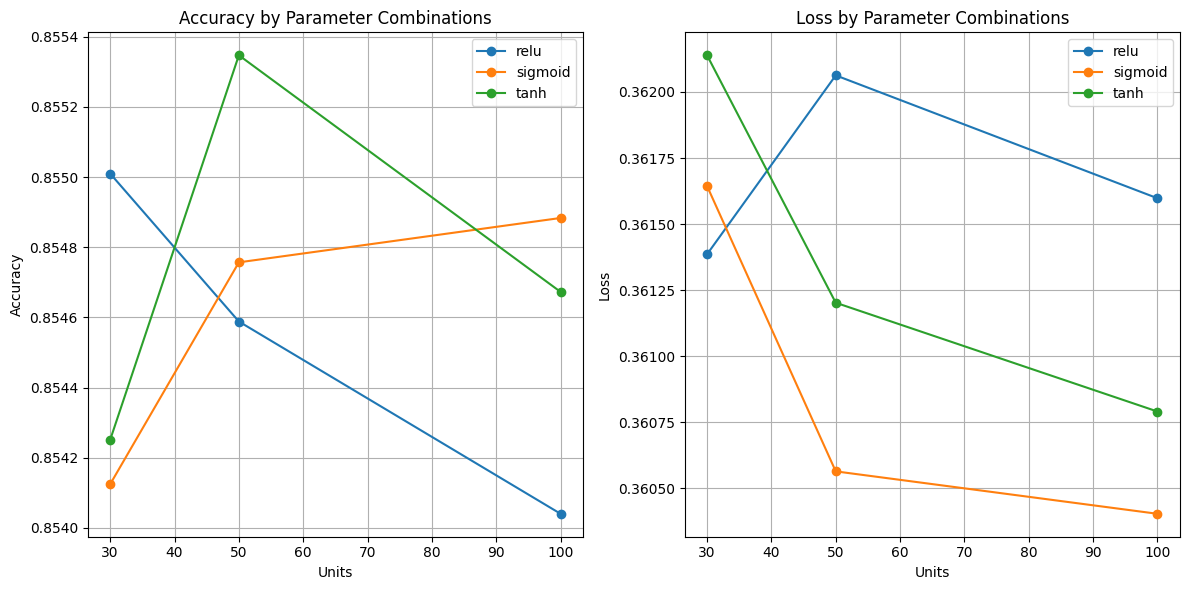

In [ ]:
# Splitting the data into training and validation sets
X_train_wide, X_valid_wide, X_train_deep, X_valid_deep, y_train, y_valid = train_test_split(
    articles_embeddings, queries_embeddings, y_train, test_size=0.2, random_state=42
)

# Adapt normalization layers to training data
norm_wide_layer.adapt(X_train_wide)
norm_deep_layer.adapt(X_train_deep)

# Check the sizes of training and validation data
print("Sizes of Training Data:", len(X_train_wide), len(X_train_deep), len(y_train))
print("Sizes of Validation Data:", len(X_valid_wide), len(X_valid_deep), len(y_valid))


Sizes of Training Data: 15806 15806 15806
Sizes of Validation Data: 3952 3952 3952


Trying configuration: {'activation': 'relu', 'hidden_layers': (30,), 'output_activation': 'sigmoid', 'units': 30}
124/124 [==============================] - 0s 1ms/step - loss: 0.3547 - accuracy: 0.8548
Trying configuration: {'activation': 'relu', 'hidden_layers': (30,), 'output_activation': 'sigmoid', 'units': 50}
124/124 [==============================] - 0s 1ms/step - loss: 0.3548 - accuracy: 0.8550
Trying configuration: {'activation': 'relu', 'hidden_layers': (30,), 'output_activation': 'sigmoid', 'units': 100}
124/124 [==============================] - 0s 1ms/step - loss: 0.3546 - accuracy: 0.8560
Trying configuration: {'activation': 'relu', 'hidden_layers': (50,), 'output_activation': 'sigmoid', 'units': 30}
124/124 [==============================] - 0s 1ms/step - loss: 0.3551 - accuracy: 0.8548
Trying configuration: {'activation': 'relu', 'hidden_layers': (50,), 'output_activation': 'sigmoid', 'units': 50}
124/124 [==============================] - 0s 1ms/step - loss: 0.3582 - a

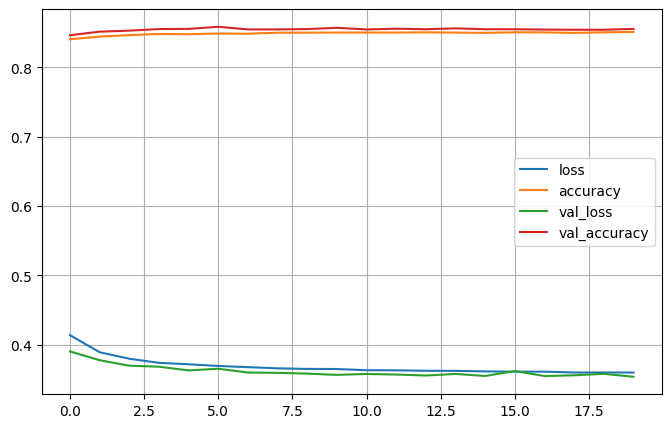

In [ ]:
# input layers for wide and deep inputs
input_articles = keras.layers.Input(shape=[50], name="wide_input")
input_queries = keras.layers.Input(shape=[50], name="deep_input")

# normalization layers
norm_wide_layer = keras.layers.Normalization(axis=None)
norm_deep_layer = keras.layers.Normalization(axis=None)
norm_wide = norm_wide_layer(input_articles)
norm_deep = norm_deep_layer(input_queries)

# deep layers
hidden1 = keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)

# Concatenation wide and deep outputs
concat = keras.layers.Concatenate()([norm_wide, hidden2])
output = keras.layers.Dense(1, activation='sigmoid')(concat)

class WideAndDeepModel(keras.Model):
    def __init__(self, units=30, activation="relu", output_activation="sigmoid", hidden_layers=(30,), **kwargs):
        super().__init__(**kwargs)
        self.norm_layer_wide = keras.layers.Normalization()
        self.norm_layer_deep = keras.layers.Normalization()
        self.hidden_layers = [keras.layers.Dense(units, activation=activation) for _ in range(len(hidden_layers))]
        self.main_output = keras.layers.Dense(1, activation=output_activation)

    def call(self, inputs):
        input_wide, input_deep = inputs
        norm_wide = self.norm_layer_wide(input_wide)
        norm_deep = self.norm_layer_deep(input_deep)
        deep = norm_deep
        for layer in self.hidden_layers:
            deep = layer(deep)
        concat = keras.layers.concatenate([norm_wide, deep])
        main_output = self.main_output(concat)
        return main_output

param_grid = {
    'units': [30, 50, 100],
    'activation': ['relu', 'tanh', 'sigmoid'],
    'output_activation': ['sigmoid'],
    'hidden_layers': [(30,), (50,), (100,), (30, 30), (50, 50), (100, 100)]
}

results = []
#callbacks
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

# parameter combinations
for params in ParameterGrid(param_grid):
    print("Trying configuration:", params)

    #initialize and compile
    model = WideAndDeepModel(**params)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    #fit
    history = model.fit(
        [X_train_wide, X_train_deep], y_train, epochs=20,
        validation_data=([X_valid_wide, X_valid_deep], y_valid),
        callbacks=[early_stopping], verbose=0
    )

    #evaluate
    loss, accuracy = model.evaluate([X_valid_wide, X_valid_deep], y_valid)
    results.append({'params': params, 'accuracy': accuracy, 'history': history})


best_model = max(results, key=lambda x: x['accuracy'])
print("Best model configuration:", best_model['params'])
print("Best model accuracy:", best_model['accuracy'])

#Plot
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()


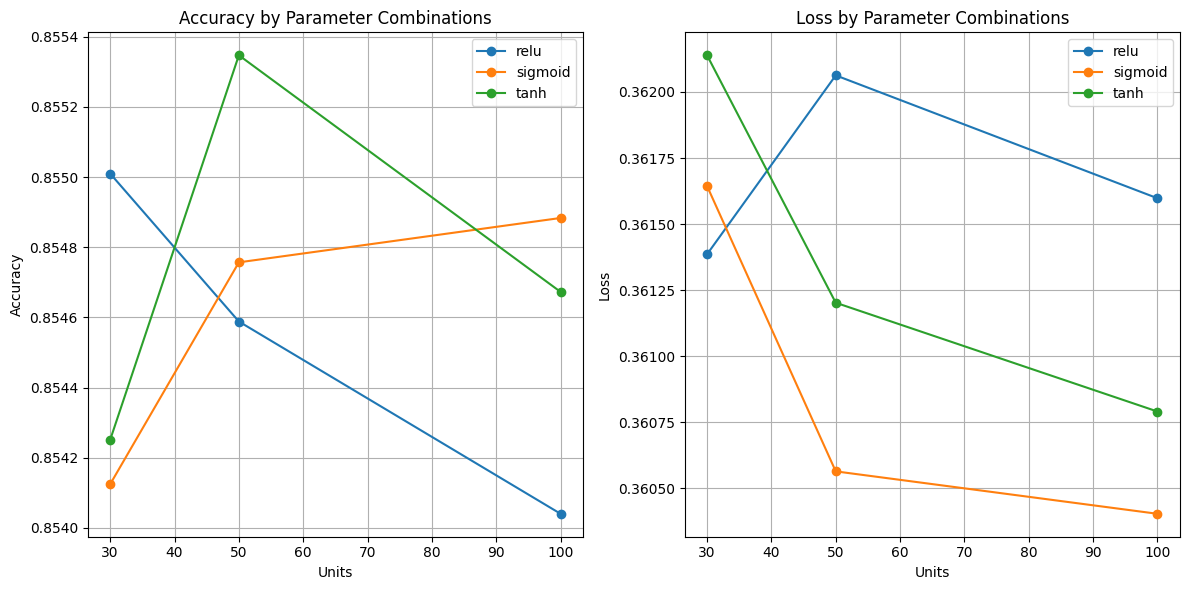

In [ ]:
# parameter configurations and corresponding accuracy and loss results to df
params_list = [result['params'] for result in results]
accuracies = [result['accuracy'] for result in results]
losses = [result['history'].history['loss'][-1] for result in results]

results_df = pd.DataFrame({
    'Units': [params['units'] for params in params_list],
    'Activation': [params['activation'] for params in params_list],
    'Accuracy': accuracies,
    'Loss': losses
})

# results by activation function and units. mean acc & loss
grouped_results = results_df.groupby(['Activation', 'Units']).mean().reset_index()

# plots
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for activation, group in grouped_results.groupby('Activation'):
    plt.plot(group['Units'], group['Accuracy'], label=activation, marker='o')
plt.title('Accuracy by Parameter Combinations')
plt.xlabel('Units')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()


plt.subplot(1, 2, 2)
for activation, group in grouped_results.groupby('Activation'):
    plt.plot(group['Units'], group['Loss'], label=activation, marker='o')
plt.title('Loss by Parameter Combinations')
plt.xlabel('Units')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


## **RNN**

The RNN models developed include LSTM and GRU. The units explored in the model were 50, 100, 150, 200 and 250 with activation options of tahn and sigmoid. The best configuration was the LSTM model with 150 units using the tanh activation.

The highest accuracy was with 150 units, after which accuracy decreases. This indicates that adding more units did not improve the model’s performance.

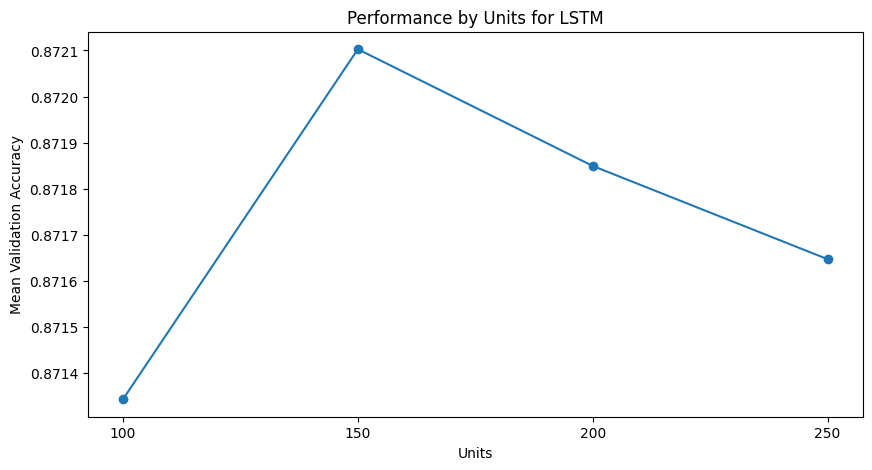

The highest accuracy was with 100 units, after which accuracy fluctuated and remained low. This indicates that adding more units did not improve the model’s performance.

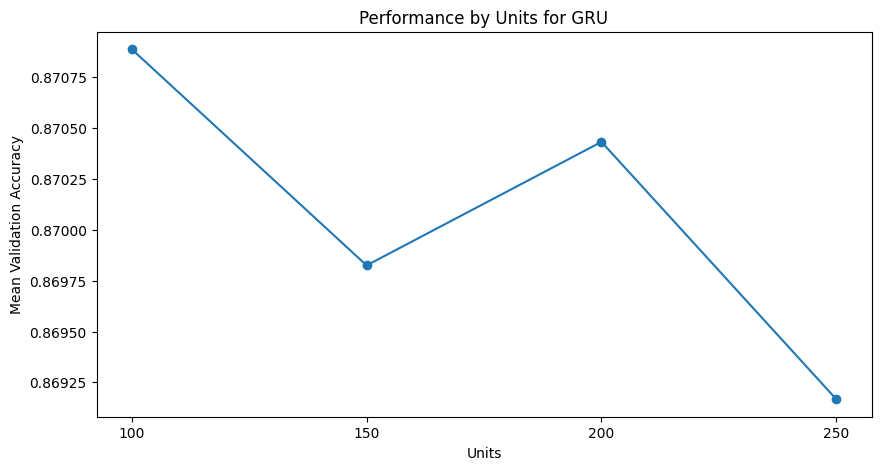

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

class RNNTrainer:
    def __init__(self, input_shape_article, input_shape_query, output_units, epochs=10, batch_size=32, n_splits=5):
        self.input_shape_article = input_shape_article
        self.input_shape_query = input_shape_query
        self.output_units = output_units
        self.epochs = epochs
        self.batch_size = batch_size
        self.n_splits = n_splits
        self.performance_records = {}
        self.best_model = None
        self.best_accuracy = 0

    def build_model(self, rnn_unit_type='LSTM', units=50, activation='tanh', recurrent_activation='sigmoid'):
        input_article = Input(shape=self.input_shape_article, name='Article_Input')
        input_query = Input(shape=self.input_shape_query, name='Query_Input')

        if rnn_unit_type == 'LSTM':
            article_rnn = LSTM(units, activation=activation, recurrent_activation=recurrent_activation)(input_article)
            query_rnn = LSTM(units, activation=activation, recurrent_activation=recurrent_activation)(input_query)
        elif rnn_unit_type == 'GRU':
            article_rnn = GRU(units, activation=activation, recurrent_activation=recurrent_activation)(input_article)
            query_rnn = GRU(units, activation=activation, recurrent_activation=recurrent_activation)(input_query)

        concatenated = concatenate([article_rnn, query_rnn])
        output = Dense(self.output_units, activation='sigmoid')(concatenated)

        model = Model(inputs=[input_article, input_query], outputs=output)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

    def train_and_evaluate(self, articles_train, queries_train, y_train, rnn_unit_options, units_options, activations_options):
        X_dummy = np.zeros((articles_train.shape[0], 1))
        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)

        for rnn_unit in rnn_unit_options:
            for units in units_options:
                for activation, recurrent_activation in activations_options:
                    fold_accuracies = []
                    for train_index, val_index in skf.split(X_dummy, y_train):
                        X_article_train_fold, X_article_val_fold = articles_train[train_index], articles_train[val_index]
                        X_query_train_fold, X_query_val_fold = queries_train[train_index], queries_train[val_index]
                        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

                        model = self.build_model(rnn_unit_type=rnn_unit, units=units,
                                                 activation=activation, recurrent_activation=recurrent_activation)
                        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
                        model.fit([X_article_train_fold, X_query_train_fold], y_train_fold,
                                  validation_data=([X_article_val_fold, X_query_val_fold], y_val_fold),
                                  epochs=self.epochs, batch_size=self.batch_size, callbacks=[early_stopping], verbose=0)

                        val_accuracy = model.evaluate([X_article_val_fold, X_query_val_fold], y_val_fold, verbose=0)[1]
                        fold_accuracies.append(val_accuracy)

                    mean_val_accuracy = np.mean(fold_accuracies)
                    self.performance_records[(rnn_unit, units, activation)] = mean_val_accuracy
                    if mean_val_accuracy > self.best_accuracy:
                        self.best_accuracy = mean_val_accuracy
                        self.best_model = model
                        self.best_config = (rnn_unit, units, activation)

        print(f"Best configuration: {self.best_config} with accuracy {self.best_accuracy}")

    def predict(self, articles_test, queries_test):
        if self.best_model:
            return self.best_model.predict([articles_test, queries_test])
        else:
            raise ValueError("No best model to predict. Please run train_and_evaluate first.")

    def save_model(self, file_path):
        if self.best_model:
            self.best_model.save(file_path)
        else:
            raise ValueError("No best model to save. Please run train_and_evaluate first.")

    def load_model(self, file_path):
        self.best_model = tf.keras.models.load_model(file_path)

    def plot_performance_by_units(self, rnn_unit):
    # Plotting performance by the number of units
        unit_performance = {key[1]: val for key, val in self.performance_records.items() if key[0] == rnn_unit}
        units = list(unit_performance.keys())
        performances = list(unit_performance.values())

        plt.figure(figsize=(10, 5))
        plt.plot(units, performances, marker='o')
        plt.title(f'Performance by Units for {rnn_unit}')
        plt.xlabel('Units')
        plt.ylabel('Mean Validation Accuracy')
        plt.xticks(units)
        plt.show()

    def plot_performance_by_rnn_unit(self, units):
    # Plotting performance by rnn unit type
        rnn_unit_performance = {key[0]: val for key, val in self.performance_records.items() if key[1] == units}
        rnn_units = list(rnn_unit_performance.keys())
        performances = list(rnn_unit_performance.values())

        plt.figure(figsize=(10, 5))
        plt.bar(rnn_units, performances, color='skyblue')
        plt.title(f'Performance by RNN Unit with {units} Units')
        plt.xlabel('RNN Unit Type')
        plt.ylabel('Mean Validation Accuracy')
        plt.xticks(rnn_units)
        plt.show()

In [ ]:
# Correcting the shape
articles_train_rnn = np.expand_dims(articles_embeddings, axis=1)
queries_train_rnn = np.expand_dims(queries_embeddings, axis=1)

articles_test_rnn = np.expand_dims(articles_embeddings_test, axis=1)
queries_test_rnn = np.expand_dims(queries_embeddings_test, axis=1)

print(articles_train_rnn.shape)
print(queries_train_rnn.shape)


(19758, 1, 50)
(19758, 1, 50)


Best configuration: ('LSTM', 150, 'tanh') with accuracy 0.8721025586128235


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


153/153 [==============================] - 1s 2ms/step


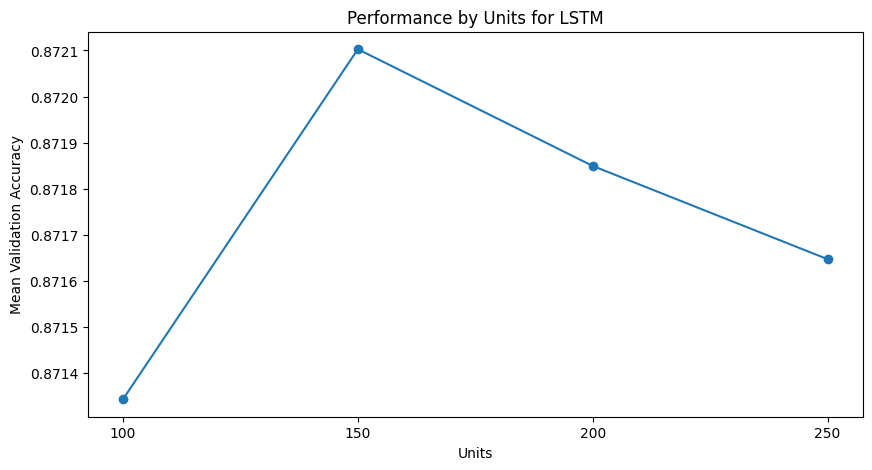

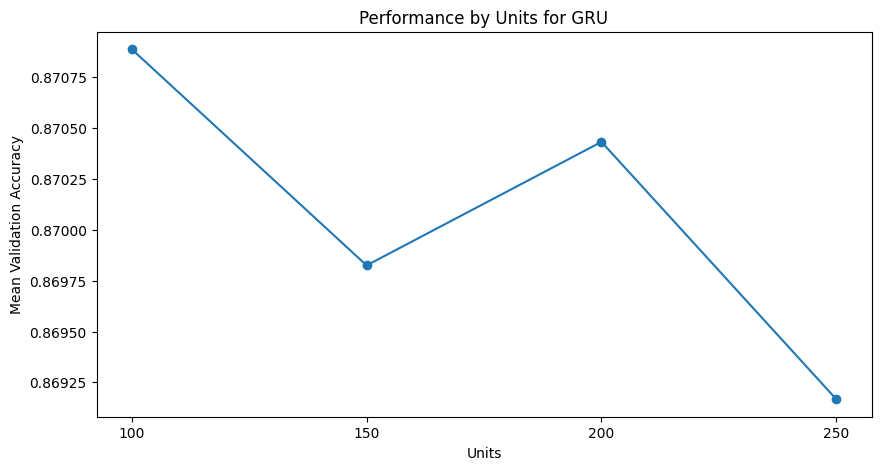

In [ ]:
# Loading data and labels
articles_train = np.load('articles_embeddings.npy')
queries_train = np.load('queries_embeddings.npy')
articles_test = np.load('articles_embeddings_test.npy')
queries_test = np.load('queries_embeddings_test.npy')
y_train = np.load('labels.npy')


articles_train_rnn = np.expand_dims(articles_train, axis=1)
queries_train_rnn = np.expand_dims(queries_train, axis=1)
articles_test_rnn = np.expand_dims(articles_test, axis=1)
queries_test_rnn = np.expand_dims(queries_test, axis=1)

#trainer with new input shape
trainer = RNNTrainer(
    input_shape_article=articles_train_rnn.shape[1:],
    input_shape_query=queries_train_rnn.shape[1:],
    output_units=1,
    epochs=10,
    batch_size=32,
    n_splits=5
)

# hyperparameters
rnn_unit_options = ['LSTM', 'GRU']
units_options = [100, 150, 200, 250]
activations_options = [('tanh', 'sigmoid')]


# Train and evaluate
trainer.train_and_evaluate(articles_train_rnn, queries_train_rnn, y_train, rnn_unit_options, units_options, activations_options)
trainer.save_model('best_rnn_model.h5')

# can load the best model below, if needed
# trainer.load_model('best_rnn_model.h5')

#Predict with best
predictions = trainer.predict(articles_test_rnn, queries_test_rnn)
binary_predictions_rnn = (predictions >= 0.5).astype(int) # pred to binary

# plot
trainer.plot_performance_by_units(rnn_unit='LSTM')
trainer.plot_performance_by_units(rnn_unit='GRU')


In [ ]:
# results to csv

binary_predictions_1d = np.squeeze(binary_predictions_rnn)


submission = pd.DataFrame({
    'id': test_clean['doc_id'],
    'judgement': binary_predictions_1d
})

submission.to_csv('complex_rnn.csv', index=False)

Best configuration: ('LSTM', 150, 'tanh') with accuracy 0.8760503053665161


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


153/153 [==============================] - 2s 4ms/step


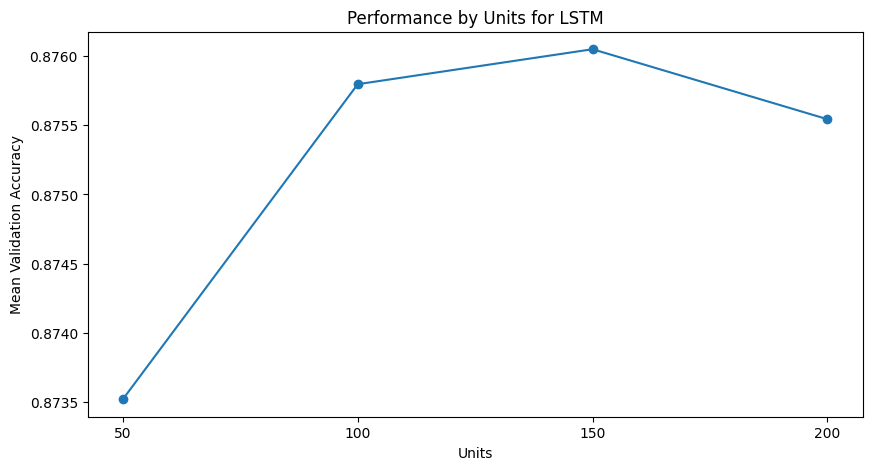

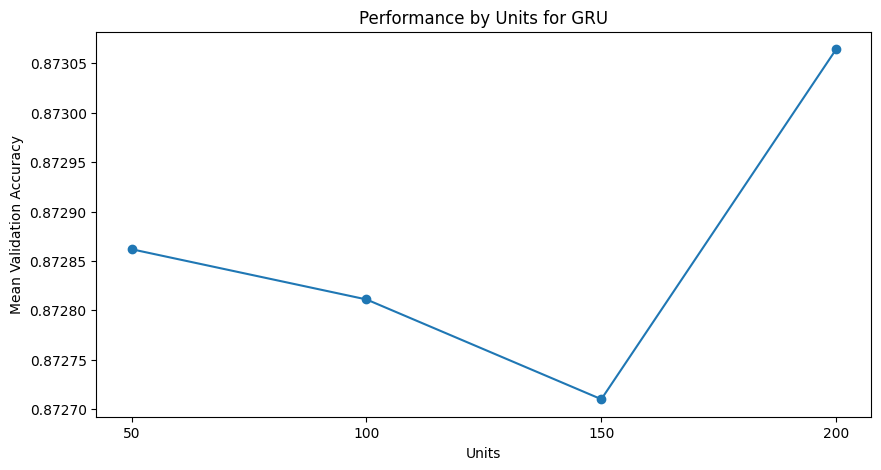

In [ ]:
articles_train = np.load('articles_embeddings.npy')
queries_train = np.load('queries_embeddings.npy')
articles_test = np.load('articles_embeddings_test.npy')
queries_test = np.load('queries_embeddings_test.npy')
y_train = np.load('labels.npy')

articles_train_rnn = np.expand_dims(articles_train, axis=1)
queries_train_rnn = np.expand_dims(queries_train, axis=1)
articles_test_rnn = np.expand_dims(articles_test, axis=1)
queries_test_rnn = np.expand_dims(queries_test, axis=1)

trainer = RNNTrainer(
    input_shape_article=articles_train_rnn.shape[1:],
    input_shape_query=queries_train_rnn.shape[1:],
    output_units=1,
    epochs=10,
    batch_size=32,
    n_splits=5
)


rnn_unit_options = ['LSTM', 'GRU']
units_options = [50, 100, 150, 200]
activations_options = [('tanh', 'sigmoid')]


trainer.train_and_evaluate(articles_train_rnn, queries_train_rnn, y_train, rnn_unit_options, units_options, activations_options)
trainer.save_model('best_rnn_model.h5')

# can load the best model here, if needed
# trainer.load_model('best_rnn_model.h5')


predictions = trainer.predict(articles_test_rnn, queries_test_rnn)
binary_predictions_rnn = (predictions >= 0.5).astype(int)


trainer.plot_performance_by_units(rnn_unit='LSTM')
trainer.plot_performance_by_units(rnn_unit='GRU')


# **Results**

Across various neural network architectures, our models received good accuracy scores. Given that the training data itself required a lot of preprocessing and even included incorrect relevancy scores for some instances, each neural network model adapted well to identify patterns, intricacies and relationships in the news articles dataset. Where possible, multiple iterations (beyond the epoch iterations within the models themselves) were run for each neural network. This ensured that we could capture the mean accuracy score of any given architecture and potential mitigate randomness, especially as each run would take different splits of the data.

Across the board, the relu activation function performed consistently well, namely for the three-layer architecture, the deep neural networks and the wide and deep neural networks. Compared to other activation functions, it is more simplistic with an aggressive decision line and no maximum output value; this helped to mitigate the vanishing gradient problem in which learning rates of parameters become increasingly small.

Consistently amongst different neural networks, we found that the optimal number of neurons per layer was between 128 and 256. Whilst initially it may seem that adding more neurons is an intuitive way to compute more features, we found that by having too many unimportant features in training, the models would begin to overfit and learning would plateau or decrease. For instance, in the three-layer neural network, 256 neurons resulted in 88.697% accuracy whilst 128 neurons had 88.50%.

In our standard baseline model classifiers, we tested both word2vec inputs and TfIDf vectorised inputs. We found that TfIDf inputs performed poorly and learned too slowly because of the large amount of inputs, this may be because of the extremely large dictionary (corpus) it had to work with, which was the length of every unique word in the cleaned database. With word2vec, however, our best accuracy score was captured at 89.02%. This was with ensemble learning methods using a random forest classifier, which is a collection of multiple decision trees trained on separate splits in the data then joined together.

We tested a deep neural network with six and seven layers. Our six-layer model performed slightly better than our seven layer, with 88.55% and 88.52% respectively. However, our wide and deep models with relu and 100 layers and sigmoid and 30 layers scored 85.63% and 85.60% respectively.

Our complex recurrent neural networks performed similarly but marginally worse than above, with LSTM scoring a mean accuracy of 87.41%.

Model name  | Iteration | Configuration / Best Performance | Accuracy Score| Mean | Standard Deviation
-------------------|------------------|----------------|----------|-------|----|
Standard Baseline | 1 | Word2Vec - Random Forest | 0.89017| - |- |
 | 2 | Word2Vec - Random Forest | 0.89139 | - | - |
 |  | |  | 0.8908 | 0.0009 |
| 1| TfIDf - Random Forest | 0.88511 | - | - |
| 2 | TfIDf - Support Vector Machine | 0.88646 | - | - |
|  |  |  | 0.8851 | 0.0010 |
| |  |  |  |  |
3L NN BL | 1 | Neurons: 128, Activation: relu | 0.88504 | - |-|
 | 2 | Neurons: 256, Activation: relu | 0.88697 | - |- |
 |  |  |  | 0.8860 | 0.0014|
 | |  |  |  |  |
Deep NN | 1 | Layers: 6, Neurons: 256, Activation: 'relu',  Initialiser: 'he_normal',  Regularisation: None, Learning Rate: 0.001  | 0.88551 | - | - |
 | 2 | Layers: 7, Neurons: 256, Activation: 'relu',  Initialiser: 'he_normal',  Regularisation: None, Learning Rate: 0.001 | 0.88526 | - | - |
  |  |  | | 0.8854 | 0.0002 |
  | |  |  |  |  |
RNN | 1 | LSTM, Units: 150, Activation: 'tanh' | 0.8721 | - | - |
 | 2 | LSTM, Units: 150, Activation: 'tanh' | 0.8741 | - | - |
 |  |  |  | 0.8741 | 0.0028 |
 | |  |  |  |  |
Wide and Deep | 1 | Activation': 'relu', Hidden layers: (100, 100), Output activation: 'sigmoid', Units: 30 | 0.85628 | - | - |
 | 2 |Activation': 'sigmoid', Hidden layers: (30,), Output activation: 'sigmoid', Units: 50 |0.85602  | - | - |
|  |  |  | 0.8562 | 0.0002 |

Model name  | Kaggle Score
-------------------|------------------|
Standard Baseline | 0.87305 |
3L NN | 0.86950 |
Deep NN | 0.87114 |
RNN | 0.86814 |
Wide and Deep |0.87223  |

# **Summary**

The best performing model for this task is standard ML baseline random forest model. This model used Word2Vec. The model’s mean performance was 89.1% and scored 87.3% on Kaggle. This Kaggle score is at the top of the leader board.  



While the standard ML model performed better than neural networks, it does not necessarily imply that this type of model is ideally suited for text relevance tasks. Various factors could have influenced the results such as the dataset being too small and data linearity. Therefore, the recommended model is the 3-layer baseline model which had a mean accuracy of 88.6% and a Kaggle score of 87%. The score is within the top 5% of the leaderboard on Kaggle.



Making financial investments in the Pro version of Google Colab, will allow for the development of more complex and computationally heavy models such as BERT. Using such pretrained models can assist in increasing the performance of the model (Htait, 2021).   

# **References**

Azzopardi, L. (2024). ‘Processing Text Features’, CS985: Machine Learning for Data Analytics. Available at: https://classes.myplace.strath.ac.uk/course/view.php?id=22388 (Accessed: 07 April 2024).

Géron, A. (2019) Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems. O'REILLY.



Htait, A. (2021). ‘BERT’, CS985: Machine Learning for Data Analytics. Available at: https://classes.myplace.strath.ac.uk/mod/resource/view.php?id=1498815 (Accessed: 07 April 2024).

